In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
oecd = pd.read_csv('oecd.csv')
oecd = oecd.melt(id_vars='country', var_name='date', value_name='value')
oecd.index = pd.to_datetime(oecd['date'])

In [11]:
country_means = oecd.groupby('country')['value'].mean()
top_countries = country_means.nlargest(10).index
filtered_oecd = oecd[oecd['country'].isin(top_countries)]

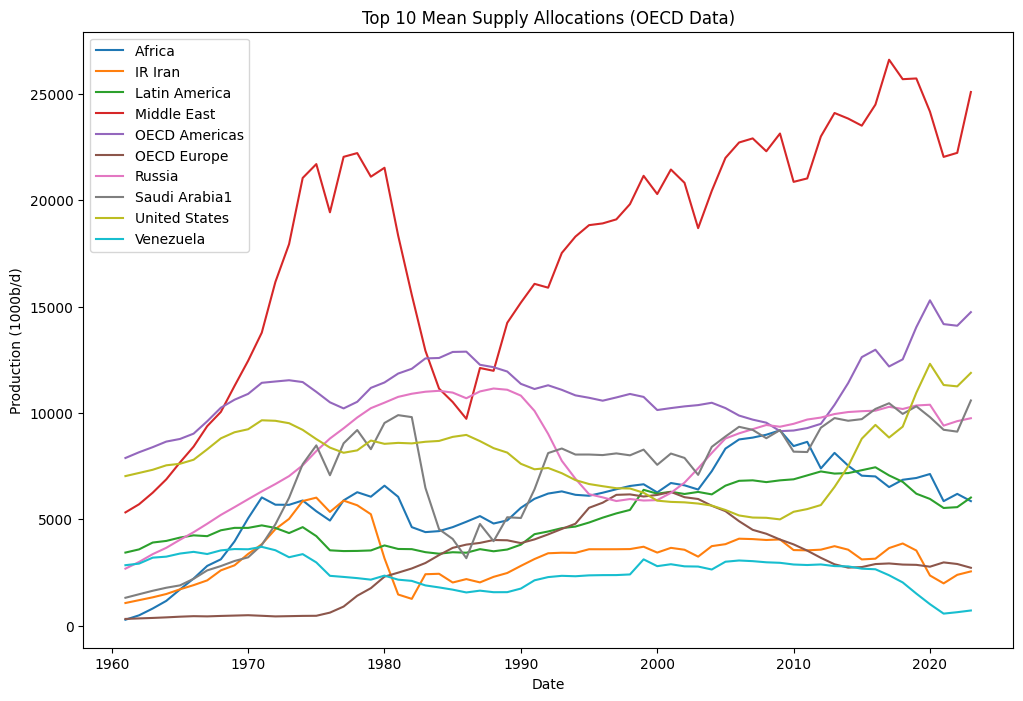

In [12]:
plt.figure(figsize=(12, 8))
for label, grp in filtered_oecd.groupby('country'):
    plt.plot(grp.index, grp['value'], label=label)

plt.title('Top 10 Mean Supply Allocations (OECD Data)')
plt.xlabel('Date')
plt.ylabel('Production (1000b/d)')
plt.legend()
plt.show()

In [15]:
opec = pd.read_csv('opec.csv')
opec = opec.melt(id_vars='country', var_name='date', value_name='value')
opec['date'] = pd.to_datetime(opec['date'])

C:\Users\andre\AppData\Local\Temp\ipykernel_31152\922623393.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  opec['date'] = pd.to_datetime(opec['date'])


In [16]:
country_means = opec.groupby('country')['value'].mean()
top_countries = country_means.nlargest(7).index
filtered_opec = opec[opec['country'].isin(top_countries)]

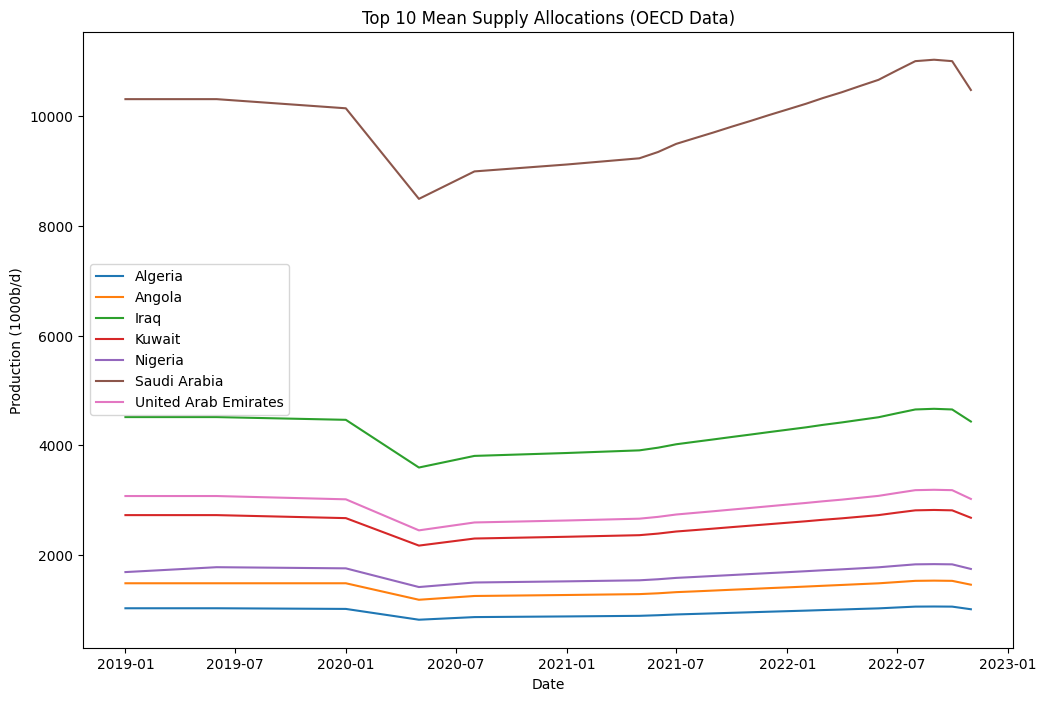

In [17]:
plt.figure(figsize=(12, 8))
for label, grp in filtered_opec.groupby('country'):
    plt.plot(grp['date'], grp['value'], label=label)

plt.title('Top 10 Mean Supply Allocations (OECD Data)')
plt.xlabel('Date')
plt.ylabel('Production (1000b/d)')
plt.legend()
plt.show()

([<matplotlib.axis.XTick at 0x1f6d81bd1d0>,
 [Text(0.0, 0, '01/1/2010'),
  Text(156.0, 0, '12/28/2012'),
  Text(312.0, 0, '12/25/2015'),
  Text(468.0, 0, '12/21/2018'),
  Text(624.0, 0, '12/17/2021')])

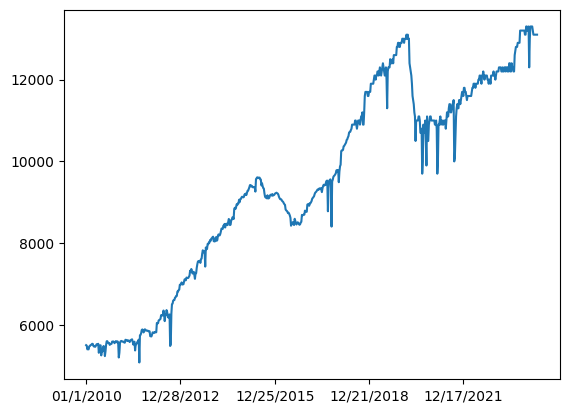

In [18]:
eia = pd.read_csv('eia.csv') 
plt.plot(eia['date'], eia['production'])
plt.xticks(eia['date'][::156])

In [19]:
oecd['date'] = pd.to_datetime(oecd['date'])
eia['date'] = pd.to_datetime(eia['date'])

oecd_data = oecd.resample('M', on='date').sum()
opec_data = opec.resample('M', on='date').sum()
eia_data = eia.resample('M', on='date').sum()

In [20]:
data = pd.concat([oecd_data, opec_data, eia_data], axis=1)
data.fillna(method='ffill', inplace=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_31152\1141644132.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [22]:
data['Lagged_Production'] = data['production'].shift(1)
data['Rolling_Mean'] = data['production'].rolling(window=12).mean()
data.dropna(inplace=True)

In [24]:
import prophet

df_prophet = data.reset_index()[['date', 'production', 'Lagged_Production', 'Rolling_Mean']].rename(columns={'date': 'ds', 'production': 'y'})
# Initialize and fit the model
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.add_regressor('Lagged_Production')
model.add_regressor('Rolling_Mean')
model.fit(df_prophet)

# Future dataframe for predictions
future = model.make_future_dataframe(periods=12, freq='M')

last_known_lagged = data['Lagged_Production'].iloc[-1]
last_known_rolling = data['Rolling_Mean'].iloc[-1]

future['Lagged_Production'] = last_known_lagged
future['Rolling_Mean'] = last_known_rolling

# Forecast
forecast = model.predict(future)

14:22:37 - cmdstanpy - INFO - Chain [1] start processing
14:22:37 - cmdstanpy - INFO - Chain [1] done processing


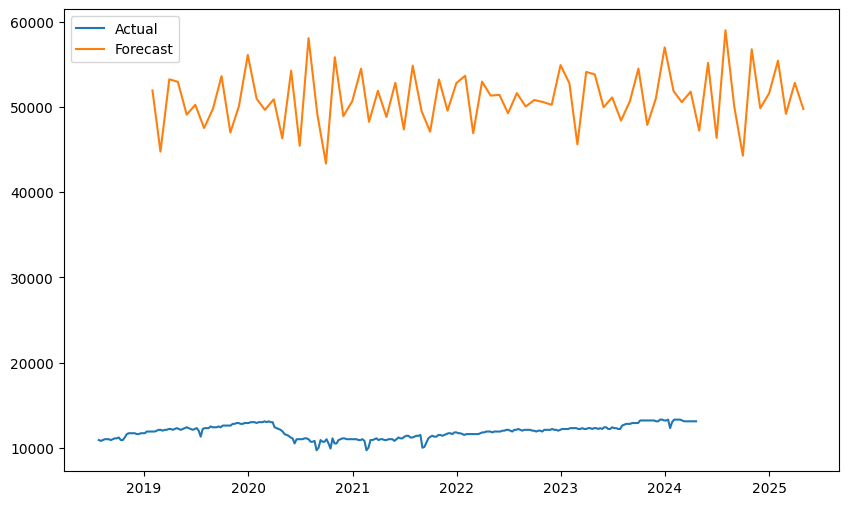

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(eia['date'][-300:], eia['production'][-300:], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.legend()
plt.show()

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

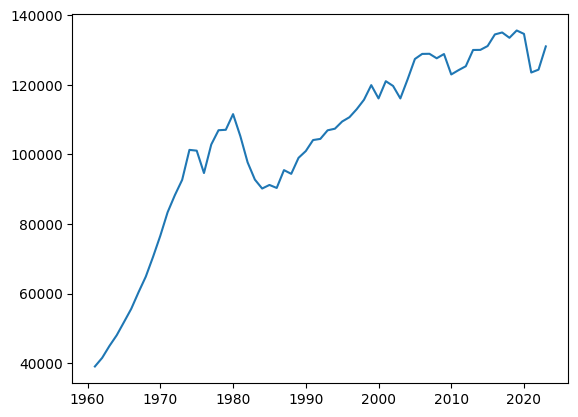

In [60]:
oecd = pd.read_csv('oecd.csv')
oecd.drop(columns = ['country'], inplace = True)
oecd = oecd.sum()
oecd = oecd.to_frame(name='OECD')
oecd.index.name = 'date'
oecd.index = pd.to_datetime(oecd.index)
oecd_weekly = oecd.resample('W').ffill()

plt.plot(oecd)

C:\Users\andre\AppData\Local\Temp\ipykernel_31152\3410648856.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  opec.index = pd.to_datetime(opec.index)


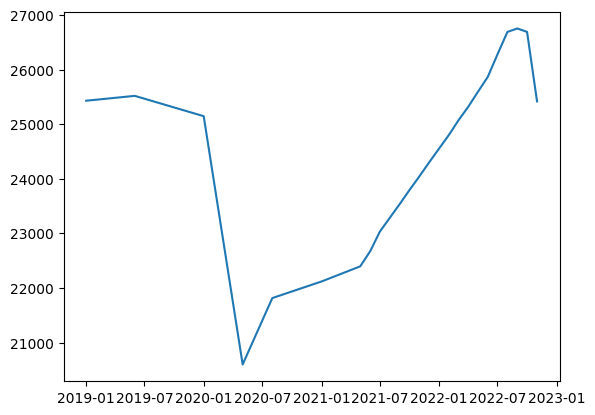

In [63]:
opec = pd.read_csv('opec.csv')
opec.drop(columns = ['country'], inplace = True)
opec = opec.sum()
opec = opec.to_frame(name='OPEC')
opec.index.name = 'date'
opec.index = pd.to_datetime(opec.index)
opec_weekly = opec.resample('W').ffill()

plt.plot(opec)

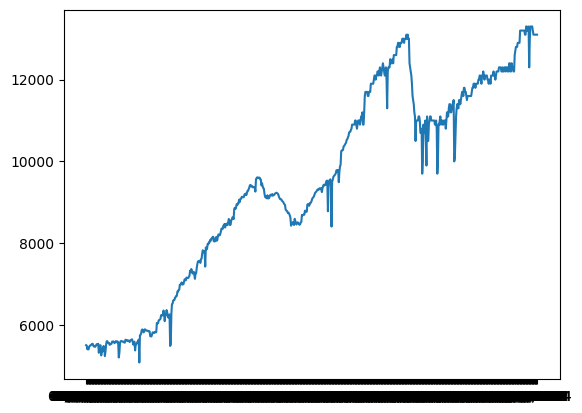

In [64]:
eia = pd.read_csv('eia.csv')
plt.plot(eia['date'], eia['production'])

In [77]:
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


# merged_data = pd.merge_asof(eia.sort_index(), opec.sort_index(), on='date')
# merged_data = pd.merge_asof(merged_data, oecd.sort_index(), on='date')


data = pd.DataFrame({
    'EIA': eia[-201:]['production'].values.flatten(),
    'OECD': oecd_weekly[-201:].values.flatten(),
    'OPEC': opec_weekly[-201:].values.flatten()
})

data.dropna(inplace=True)

features = data[['OECD', 'OPEC']]
target = data['EIA']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Fit the model
model = OLS(target, sm.add_constant(features_scaled))
results = model.fit()

# Print summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    EIA   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     194.4
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           1.92e-47
Time:                        14:38:59   Log-Likelihood:                -1528.7
No. Observations:                 201   AIC:                             3063.
Df Residuals:                     198   BIC:                             3073.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.181e+04     34.557    341.894      0.0

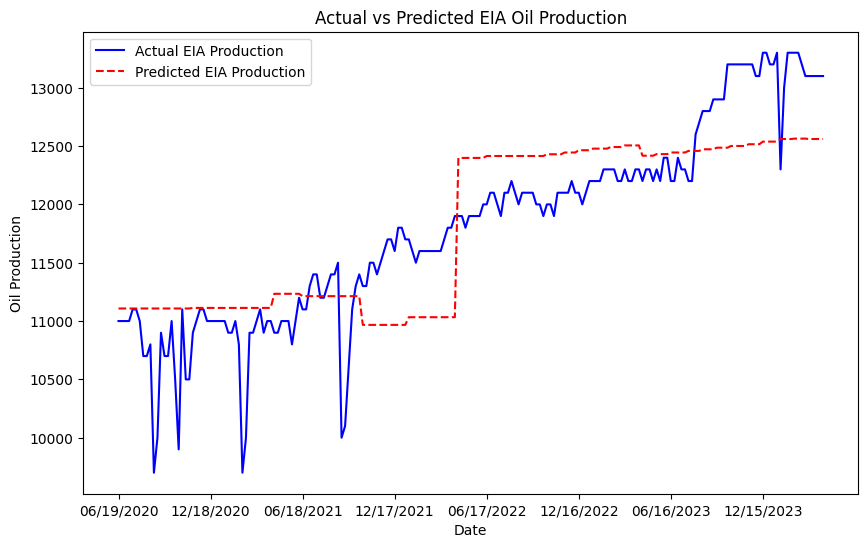

In [84]:
predictions = results.predict(sm.add_constant(features_scaled))
plt.figure(figsize=(10, 6))
plt.plot(eia['date'][-201:-1], target[:-1], label='Actual EIA Production', color='blue')
plt.plot(eia['date'][-201:-1], predictions[:-1], label='Predicted EIA Production', color='red', linestyle='--')
plt.xticks(eia['date'][-201:-1][::26])
plt.title('Actual vs Predicted EIA Oil Production')
plt.xlabel('Date')
plt.ylabel('Oil Production')
plt.legend()
plt.show()